# Deep_learning scratch

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

## ディープニューラルネットワークスクラッチ

前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。


このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。


名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。

### 層などのクラス化

クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。


手を加える箇所


- 層の数
- 層の種類（今後畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。


実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。


**《サンプルコード1》**

ScratchDeepNeuralNetrowkClassifierのfitメソッド内

self.sigma : ガウス分布の標準偏差

self.lr : 学習率

self.n_nodes1 : 1層目のノード数

self.n_nodes2 : 2層目のノード数

self.n_output : 出力層のノード数


optimizer = SGD(self.lr)

self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)

self.activation1 = Tanh()

self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)

self.activation2 = Tanh()

self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)

self.activation3 = Softmax()

**《サンプルコード2》**


イテレーションごとのフォワード

A1 = self.FC1.forward(X)

Z1 = self.activation1.forward(A1)

A2 = self.FC2.forward(Z1)

Z2 = self.activation2.forward(A2)

A3 = self.FC3.forward(Z2)

Z3 = self.activation3.forward(A3)

**《サンプルコード3》**


イテレーションごとのバックワード

dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている

dZ2 = self.FC3.backward(dA3)

dA2 = self.activation2.backward(dZ2)

dZ1 = self.FC2.backward(dA2)

dA1 = self.activation1.backward(dZ1)

dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

### 【問題1】全結合層のクラス化

全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。

In [3]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.optimizer = optimizer
        self.X = None
        self.dW = None
        self.dB = None

    def forward(self, X): 
        self.X = X
        A = np.dot(X, self.W) + self.B
        return A

    def backward(self, dA):
        dW = np.dot(self.X.T, dA)
        dB =  np.sum(dA, axis=0)
        dZ =  np.dot(dA, self.W.T)

        self.optimizer.update(self, dW, dB) # 更新
        return dZ

### 【問題2】初期化方法のクラス化

初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [4]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### 【問題3】最適化手法のクラス化

最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [5]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dW, dB):
        layer.W -= self.lr * dW
        layer.B -= self.lr * dB
        return self

### 【問題4】活性化関数のクラス化

活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。


#### 発展的要素
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

In [6]:
# sigmoid関数のクラス
class Sigmoid:
    def forward(self, A):
        A = -709*(A <= -709) + A*(A > -709) # オーバーフロー対策
        self.Z = 1 / (1 + np.exp(-A))
        return self.Z
    
    def backward(self, dZ):
        dA = dZ * self.Z * (1- self.Z)
        return dA

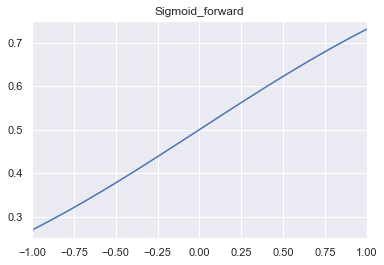

In [7]:
# 可視化する（forwardのみ）
sns.set()
X = np.arange(-8, 8, 0.1)
Y = Sigmoid().forward(X)
plt.plot(X,Y)
plt.xlim(-1, 1)
plt.ylim(0.25, 0.75)
plt.title("Sigmoid_forward")
plt.show()

In [8]:
# Hyperbolic tangent関数のクラス
class Tanh:
    def forward(self, A):
        self.Z = np.tanh(A)  
        return self.Z

    def backward(self, dZ):
        dA = dZ * (1 - self.Z ** 2)
        return dA

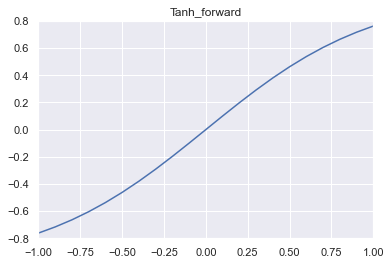

In [9]:
# 可視化する（forwardのみ）
X = np.arange(-8, 8, 0.1)
Y = Tanh().forward(X)
plt.plot(X,Y)
plt.xlim(-1, 1)
plt.ylim(-0.8, 0.8)
plt.title("Tanh_forward")
plt.show()

In [10]:
# softmax関数のクラス
class Softmax:
    def forward(self, A3):
        c = np.max(A3) # オーバーフロー対策
        Z3 = np.exp(A3 - c) / np.sum(np.exp(A3 - c), axis=1).reshape(-1, 1)
        return Z3

    def backward(self, Z3, y):
        dA3 = Z3 - y
        return dA3

### 【問題5】ReLUクラスの作成

現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。

$$
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$$

$x$ : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。

https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html

一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$$
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$$

数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。


フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [11]:
# ReLUクラス
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, A):
        self.mask = (A <= 0)
        Z = A.copy()
        Z[self.mask] = 0
        return Z

    def backward(self, dZ):
        dZ[self.mask] = 0
        dA = dZ
        return dA

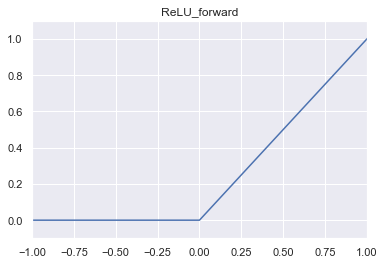

In [12]:
# 可視化する（forwardのみ）
X = np.arange(-8, 8, 0.1)
Y = ReLU().forward(X)
plt.plot(X,Y)
plt.xlim(-1, 1)
plt.ylim(-0.1, 1.1)
plt.title("ReLU_forward")
plt.show()


### 【問題6】重みの初期値

ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。

#### Xavierの初期値

Xavierの初期値における標準偏差 $\sigma$ は次の式で求められます。

$$
\sigma = \frac{1}{\sqrt{n}}
$$

$n$ : 前の層のノード数

《論文》

http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

In [13]:
# XavierInitializerクラス
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

#### Heの初期値
Heの初期値における標準偏差 $\sigma$ は次の式で求められます。

$$
\sigma = \sqrt{\frac{2}{n}}
$$

$n$ : 前の層のノード数

《論文》

https://arxiv.org/pdf/1502.01852.pdf

In [14]:
# HeInitializerクラス
class HeInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W =  self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### 【問題7】最適化手法

学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


$E()$ : ミニバッチ方向にベクトルの平均を計算


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。


更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくします。


学習率は重み一つひとつに対して異なることになります。

$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）


$H_i^{\prime}$ : 更新した $H_i$

《論文》
http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf

In [15]:
# AdaGradのクラス
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dW, dB):
        self.hW = np.zeros_like(dW)
        self.hB = np.zeros_like(dB)
        
        self.hW += dW ** 2
        self.hB += dB ** 2
        
        layer.W -= self.lr * dW / (np.sqrt(self.hW) + 1e-7)
        layer.B -= self.lr * dB / (np.sqrt(self.hB) + 1e-7)
        return self

### 【問題8】クラスの完成

任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [16]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, epochs=10, batch_size=20, optimizer="SGD", initializer="SimpleInitializer",
                 activation="Sigmoid", n_features=28*28, n_nodes1=400, n_nodes2=200, 
                 n_output=10, sigma=0.01, lr=0.01, verbose=False):
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.initializer = initializer
        self.activation = activation
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2= n_nodes2
        self.n_output= n_output
        self.sigma = sigma
        self.lr = lr
        self.verbose = verbose

    def _cross_entropy(self, y, z3): # 交差エントロピー誤差
        return  -np.sum(y * np.log(z3 + 1e-7)) / y.shape[0]
    
    def fit(self, X, y, X_val=None, y_val=None):
        if self.optimizer == "SGD": # optimizerパラメータの選択
            self.optimizer = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            self.optimizer = AdaGrad(self.lr)
        
        if self.initializer == "SimpleInitializer": # initializerパラメータの選択
            self.initializer = SimpleInitializer(self.sigma)
        elif self.initializer == "XavierInitializer":
            self.initializer = XavierInitializer()            
        elif self.initializer == "HeInitializer":        
            self.initializer = HeInitializer()
        
        if self.activation == "Sigmoid":# activationパラメータの選択
            activator1 = Sigmoid()
            activator2 = Sigmoid()
        elif self.activation == "Tanh":
            activator1 = Tanh()
            activator2 = Tanh()
        elif self.activation == "ReLU":
            activator1 = ReLU()
            activator2 = ReLU()
            
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer, self.optimizer)
        self.activation1 = activator1
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer, self.optimizer)
        self.activation2 = activator2
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer, self.optimizer)
        self.activation3 = Softmax()
        
        self.loss = []
        self.accuracy_train = []
        self.accuracy_val = []
        get_mini_batch = GetMiniBatch(X, y, self.batch_size)

        for i in range(self.epochs):
            for mini_X, mini_y in get_mini_batch:               
                A1 = self.FC1.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
            
                dA3 = self.activation3.backward(Z3, mini_y)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            self.loss.append(self._cross_entropy(mini_y, Z3)) #　交差エントロピー誤差はepochごとに計算

            if self.verbose: # verboseをTrueにした際は学習精度の推移を出力
                y_pred_train = self.predict(X)
                y_collect_train = y.argmax(axis=1)
                acc_train = accuracy_score(y_collect_train, y_pred_train)
                self.accuracy_train.append(acc_train)
                print("epoch：", i+1, "　acc_train：", acc_train)

            if hasattr(X_val, "__array__") and hasattr(y_val, "__array__"): # 検証データが入力された（array属性を有する）場合
                y_pred_val = self.predict(X_val)
                y_collect_val = y_val.argmax(axis=1)
                acc_val = accuracy_score(y_collect_val, y_pred_val)
                self.accuracy_val.append(acc_val)
                print("epoch：", i+1, "　acc_val：", acc_val)            
            
        if self.verbose: # verboseをTrueにした際は損失関数の推移を出力
            print("loss：{}".format(self.loss))
                      
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y = self.activation3.forward(A3)
        
        y_pred_test = np.argmax(y, axis=1)
        return y_pred_test

    def graphs(self): # 可視化用の関数（損失関数・学習精度）
        plt.figure(figsize=(5, 3.5))
        plt.plot(np.arange(len(self.loss)) , self.loss, linewidth = 3.0)
        plt.title("train_loss")
        plt.xlabel("epochs")
        plt.ylabel("cross_entropy_error")
        
        plt.figure(figsize=(5, 3.5))
        plt.plot(np.arange(len(self.accuracy_train)), self.accuracy_train, linewidth = 3.0, label = "train")
        if hasattr(X_val, "__array__") and hasattr(y_val, "__array__"): # 検証データが入力された場合
            plt.plot(np.arange(len(self.accuracy_val)), self.accuracy_val, linewidth = 3.0, label ="val", color="orange")
        plt.title("accuracy_score")
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.legend(frameon=True)
        plt.show()

### 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [17]:
# mnistのデータセットを読み込む
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [18]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)


(48000, 784)
(12000, 784)


In [19]:
# OneHotEncoderのサンプルコードを実行する
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(48000,)
(48000, 10)
float64


In [20]:
# 検証データ、テストデータもone-hot表現に変換する
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
print(y_val_one_hot.shape)
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
print(y_test_one_hot.shape)

(12000, 10)
(10000, 10)


In [21]:
# ミニバッチを取得するクラスを導入する
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [22]:
# optimizer="SGD"、initializer="SimpleInitializer"、activation="Sigmoid"の場合
scratch = ScratchDeepNeuralNetrowkClassifier(verbose=True)
scratch.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch： 1 　acc_train： 0.34108333333333335
epoch： 1 　acc_val： 0.3423333333333333
epoch： 2 　acc_train： 0.8357916666666667
epoch： 2 　acc_val： 0.8343333333333334
epoch： 3 　acc_train： 0.9110625
epoch： 3 　acc_val： 0.9061666666666667
epoch： 4 　acc_train： 0.9301041666666666
epoch： 4 　acc_val： 0.9245833333333333
epoch： 5 　acc_train： 0.9449791666666667
epoch： 5 　acc_val： 0.937
epoch： 6 　acc_train： 0.95375
epoch： 6 　acc_val： 0.9449166666666666
epoch： 7 　acc_train： 0.961
epoch： 7 　acc_val： 0.95275
epoch： 8 　acc_train： 0.9671458333333334
epoch： 8 　acc_val： 0.9585
epoch： 9 　acc_train： 0.9713125
epoch： 9 　acc_val： 0.9628333333333333
epoch： 10 　acc_train： 0.9745208333333333
epoch： 10 　acc_val： 0.9641666666666666
loss：[1.459121648453261, 0.29837510073852236, 0.082618013204531, 0.07385076626439596, 0.06113679890430344, 0.03873099166032621, 0.023855784317101343, 0.015563898090526418, 0.01078903783167386, 0.008072686091780582]


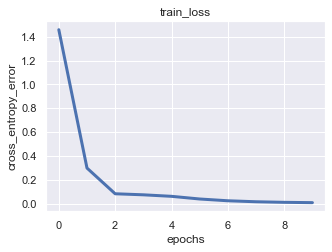

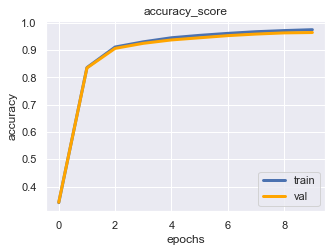

In [23]:
# 可視化する（損失関数・学習精度）
scratch.graphs()

In [24]:
# 推定、評価
y_pred = scratch.predict(X_test)
print("予測値：{}".format(y_pred))
print("正解値：{}".format(y_test))
print("Accuracy：{}".format(accuracy_score(y_test, y_pred)))

予測値：[7 2 1 ... 4 5 6]
正解値：[7 2 1 ... 4 5 6]
Accuracy：0.9661


---

In [25]:
# initializer="XavierInitializer",activation ="Tanh"の場合（optimizer="SGD"）
scratch2 = ScratchDeepNeuralNetrowkClassifier(initializer="XavierInitializer",activation ="Tanh", verbose=True)
scratch2.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch： 1 　acc_train： 0.9564166666666667
epoch： 1 　acc_val： 0.9513333333333334
epoch： 2 　acc_train： 0.9731458333333334
epoch： 2 　acc_val： 0.9650833333333333
epoch： 3 　acc_train： 0.9782916666666667
epoch： 3 　acc_val： 0.9666666666666667
epoch： 4 　acc_train： 0.9853333333333333
epoch： 4 　acc_val： 0.97125
epoch： 5 　acc_train： 0.9873541666666666
epoch： 5 　acc_val： 0.9705
epoch： 6 　acc_train： 0.9914791666666667
epoch： 6 　acc_val： 0.9734166666666667
epoch： 7 　acc_train： 0.9949166666666667
epoch： 7 　acc_val： 0.9749166666666667
epoch： 8 　acc_train： 0.9968333333333333
epoch： 8 　acc_val： 0.9768333333333333
epoch： 9 　acc_train： 0.9980208333333334
epoch： 9 　acc_val： 0.9789166666666667
epoch： 10 　acc_train： 0.998875
epoch： 10 　acc_val： 0.9778333333333333
loss：[0.02179079593714807, 0.008174608096509038, 0.004670767659436758, 0.0006192800982850695, 0.0007441615106048552, 0.000587311610052716, 0.0032840110733811136, 0.00018116291046579722, 0.00017319072756497361, 0.0005510775809492402]


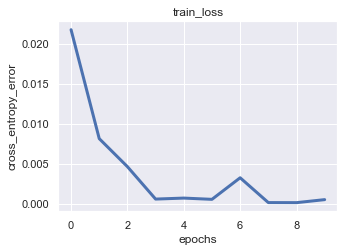

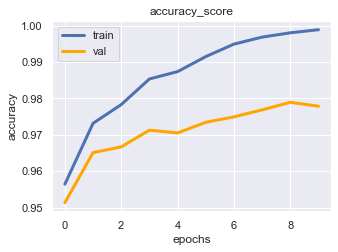

In [26]:
# 可視化する（損失関数・学習精度）
scratch2.graphs()

In [27]:
# 推定し、評価
y_pred2 = scratch2.predict(X_test)
print("予測値：{}".format(y_pred2))
print("正解値：{}".format(y_test))
print("Accuracy：{}".format(accuracy_score(y_test, y_pred2)))

予測値：[7 2 1 ... 4 5 6]
正解値：[7 2 1 ... 4 5 6]
Accuracy：0.9763


---

In [28]:
# initializer="HeInitializer",activation ="ReLU"の場合（optimizer="SGD"）
# これまでの学習率（lr=0.01）ではloss（損失関数）がキレイな右肩下がりにならなかったため、調整（lr=0.008）。
scratch3 = ScratchDeepNeuralNetrowkClassifier(initializer="HeInitializer",activation ="ReLU", lr=0.008, verbose=True)
scratch3.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch： 1 　acc_train： 0.9725833333333334
epoch： 1 　acc_val： 0.9659166666666666
epoch： 2 　acc_train： 0.9801041666666667
epoch： 2 　acc_val： 0.96725
epoch： 3 　acc_train： 0.986125
epoch： 3 　acc_val： 0.9714166666666667
epoch： 4 　acc_train： 0.9868541666666667
epoch： 4 　acc_val： 0.9729166666666667
epoch： 5 　acc_train： 0.9890625
epoch： 5 　acc_val： 0.9725
epoch： 6 　acc_train： 0.9871458333333333
epoch： 6 　acc_val： 0.9709166666666667
epoch： 7 　acc_train： 0.9944375
epoch： 7 　acc_val： 0.97575
epoch： 8 　acc_train： 0.9932916666666667
epoch： 8 　acc_val： 0.9755
epoch： 9 　acc_train： 0.9968125
epoch： 9 　acc_val： 0.978
epoch： 10 　acc_train： 0.9981041666666667
epoch： 10 　acc_val： 0.9799166666666667
loss：[0.0059108404794218725, 0.0009734871075022378, 0.0007185850032264613, 0.00020386478000015214, 0.00025496795104081775, 0.0006166589556846479, 7.922588234492952e-06, 2.161604896273773e-05, 6.579534681907703e-06, 3.84104064809116e-06]


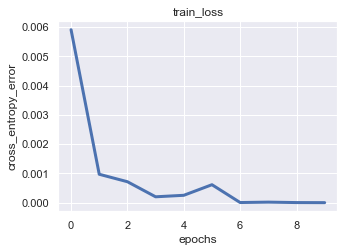

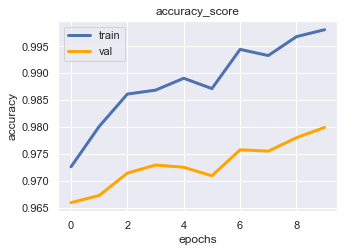

In [29]:
# 可視化する（損失関数・学習精度）
scratch3.graphs()

In [30]:
# 推定、評価
y_pred3 = scratch3.predict(X_test)
print("予測値：{}".format(y_pred3))
print("正解値：{}".format(y_test))
print("Accuracy：{}".format(accuracy_score(y_test, y_pred3)))

予測値：[7 2 1 ... 4 5 6]
正解値：[7 2 1 ... 4 5 6]
Accuracy：0.9804
